# **EDA ON AMAZON SALES DATASET**

In [371]:
#THIS HAS BEEN TAKEN FROM KAGGLE FOR IMPORTING THE DATASET

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'amazon-sales-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F2818963%2F4862520%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240927%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240927T121705Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D4afd1bf50e6e177a22875828321631821949371f6f4e97dd562a901addeeac607fa5b29ffd475fa7f19defdebf6c5b51898298f67bbcc01ab146c2829f3b12242499686da53eda1e0e1fe76d79e2b27daeb796364dcf0c6130afd82b0c5f6f5890001120843b8a8b21197e22941037f966c53b549a8c6fa6bda223bca8630d38b74a8b6db75073f078024dcfc944bcb76ad6969c05d7768efba5dc01551088854728861c2b27ba04335ea02ccd4421ef451a56d85cacf07b2859e940c3da8b82155287dec1e26b10245e5f8e17d350305a35db8f1aae76ad17b68dd5671f4a1ad6fea6213359405f64a2fed2c0bc3efaca4d7ea608c8fedf1462d20293b36b80'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 2043633 bytes downloaded
Downloaded and uncompressed: amazon-sales-dataset
Data source import complete.


In [372]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp




**IMPORTING THE DATASET**

In [373]:
df = pd.read_csv("/kaggle/input/amazon-sales-dataset/amazon.csv")

##**ANALYSIS AND DATA CLEANING**

In [374]:
df.head(5)

,product_id,product_name,category,discounted_price,actual_price,discount_percentage,rating,rating_count,about_product,user_id,user_name,review_id,review_title,review_content,img_link,product_link
0,B07JW9H4J1,Wayona Nylon Braided USB to Lightning Fast Cha...,Computers&Accessories|Accessories&Peripherals|...,₹399,"₹1,099",64%,4.2,"24,269",High Compatibility : Compatible With iPhone 12...,"AG3D6O4STAQKAY2UVGEUV46KN35Q,AHMY5CWJMMK5BJRBB...","Manav,Adarsh gupta,Sundeep,S.Sayeed Ahmed,jasp...","R3HXWT0LRP0NMF,R2AJM3LFTLZHFO,R6AQJGUP6P86,R1K...","Satisfied,Charging is really fast,Value for mo...",Looks durable Charging is fine tooNo complains...,https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Wayona-Braided-WN3LG1-Sy...
1,B098NS6PVG,Ambrane Unbreakable 60W / 3A Fast Charging 1.5...,Computers&Accessories|Accessories&Peripherals|...,₹199,₹349,43%,4.0,"43,994","Compatible with all Type C enabled devices, be...","AECPFYFQVRUWC3KGNLJIOREFP5LQ,AGYYVPDD7YG7FYNBX...","ArdKn,Nirbhay kumar,Sagar Viswanathan,Asp,Plac...","RGIQEG07R9HS2,R1SMWZQ86XIN8U,R2J3Y1WL29GWDE,RY...","A Good Braided Cable for Your Type C Device,Go...",I ordered this cable to connect my phone to An...,https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Ambrane-Unbreakable-Char...
2,B096MSW6CT,Sounce Fast Phone Charging Cable & Data Sync U...,Computers&Accessories|Accessories&Peripherals|...,₹199,"₹1,899",90%,3.9,"7,928",【 Fast Charger& Data Sync】-With built-in safet...,"AGU3BBQ2V2DDAMOAKGFAWDDQ6QHA,AESFLDV2PT363T2AQ...","Kunal,Himanshu,viswanath,sai niharka,saqib mal...","R3J3EQQ9TZI5ZJ,R3E7WBGK7ID0KV,RWU79XKQ6I1QF,R2...","Good speed for earlier versions,Good Product,W...","Not quite durable and sturdy,https://m.media-a...",https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Sounce-iPhone-Charging-C...
3,B08HDJ86NZ,boAt Deuce USB 300 2 in 1 Type-C & Micro USB S...,Computers&Accessories|Accessories&Peripherals|...,₹329,₹699,53%,4.2,"94,363",The boAt Deuce USB 300 2 in 1 cable is compati...,"AEWAZDZZJLQUYVOVGBEUKSLXHQ5A,AG5HTSFRRE6NL3M5S...","Omkar dhale,JD,HEMALATHA,Ajwadh a.,amar singh ...","R3EEUZKKK9J36I,R3HJVYCLYOY554,REDECAZ7AMPQC,R1...","Good product,Good one,Nice,Really nice product...","Good product,long wire,Charges good,Nice,I bou...",https://m.media-amazon.com/images/I/41V5FtEWPk...,https://www.amazon.in/Deuce-300-Resistant-Tang...
4,B08CF3B7N1,Portronics Konnect L 1.2M Fast Charging 3A 8 P...,Computers&Accessories|Accessories&Peripherals|...,₹154,₹399,61%,4.2,"16,905",[CHARGE & SYNC FUNCTION]- This cable comes wit...,"AE3Q6KSUK5P75D5HFYHCRAOLODSA,AFUGIFH5ZAFXRDSZH...","rahuls6099,Swasat Borah,Ajay Wadke,Pranali,RVK...","R1BP4L2HH9TFUP,R16PVJEXKV6QZS,R2UPDB81N66T4P,R...","As good as original,Decent,Good one for second...","Bought this instead of original apple, does th...",https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Portronics-Konnect-POR-1...


In [375]:
df.columns

Index(['product_id', 'product_name', 'category', 'discounted_price',
       'actual_price', 'discount_percentage', 'rating', 'rating_count',
       'about_product', 'user_id', 'user_name', 'review_id', 'review_title',
       'review_content', 'img_link', 'product_link'],
      dtype='object')

In [376]:
df.shape

(1465, 16)

In [377]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1465 entries, 0 to 1464
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   product_id           1465 non-null   object
 1   product_name         1465 non-null   object
 2   category             1465 non-null   object
 3   discounted_price     1465 non-null   object
 4   actual_price         1465 non-null   object
 5   discount_percentage  1465 non-null   object
 6   rating               1465 non-null   object
 7   rating_count         1463 non-null   object
 8   about_product        1465 non-null   object
 9   user_id              1465 non-null   object
 10  user_name            1465 non-null   object
 11  review_id            1465 non-null   object
 12  review_title         1465 non-null   object
 13  review_content       1465 non-null   object
 14  img_link             1465 non-null   object
 15  product_link         1465 non-null   object
dtypes: obj

**DROPPING UNNECESSARY COLUMNS FOR CONVENIENCE**

In [378]:
df = df.drop(columns=['user_id','user_name','review_id', 'img_link', 'product_link'])

In [379]:
df.head(5)

,product_id,product_name,category,discounted_price,actual_price,discount_percentage,rating,rating_count,about_product,review_title,review_content
0,B07JW9H4J1,Wayona Nylon Braided USB to Lightning Fast Cha...,Computers&Accessories|Accessories&Peripherals|...,₹399,"₹1,099",64%,4.2,"24,269",High Compatibility : Compatible With iPhone 12...,"Satisfied,Charging is really fast,Value for mo...",Looks durable Charging is fine tooNo complains...
1,B098NS6PVG,Ambrane Unbreakable 60W / 3A Fast Charging 1.5...,Computers&Accessories|Accessories&Peripherals|...,₹199,₹349,43%,4.0,"43,994","Compatible with all Type C enabled devices, be...","A Good Braided Cable for Your Type C Device,Go...",I ordered this cable to connect my phone to An...
2,B096MSW6CT,Sounce Fast Phone Charging Cable & Data Sync U...,Computers&Accessories|Accessories&Peripherals|...,₹199,"₹1,899",90%,3.9,"7,928",【 Fast Charger& Data Sync】-With built-in safet...,"Good speed for earlier versions,Good Product,W...","Not quite durable and sturdy,https://m.media-a..."
3,B08HDJ86NZ,boAt Deuce USB 300 2 in 1 Type-C & Micro USB S...,Computers&Accessories|Accessories&Peripherals|...,₹329,₹699,53%,4.2,"94,363",The boAt Deuce USB 300 2 in 1 cable is compati...,"Good product,Good one,Nice,Really nice product...","Good product,long wire,Charges good,Nice,I bou..."
4,B08CF3B7N1,Portronics Konnect L 1.2M Fast Charging 3A 8 P...,Computers&Accessories|Accessories&Peripherals|...,₹154,₹399,61%,4.2,"16,905",[CHARGE & SYNC FUNCTION]- This cable comes wit...,"As good as original,Decent,Good one for second...","Bought this instead of original apple, does th..."


**CHECKING AND WORKING ON NULL AND AMBIGUOUS VALUES**

In [380]:
df.isnull().sum()

,0
product_id,0
product_name,0
category,0
discounted_price,0
actual_price,0
discount_percentage,0
rating,0
rating_count,2
about_product,0
review_title,0


In [381]:
# Changing the data type of discounted price and actual price
df['discounted_price'] = df['discounted_price'].str.replace("₹",'')
df['discounted_price'] = df['discounted_price'].str.replace(",",'')
df['discounted_price'] = df['discounted_price'].astype('float64')

df['actual_price'] = df['actual_price'].str.replace("₹",'')
df['actual_price'] = df['actual_price'].str.replace(",",'')
df['actual_price'] = df['actual_price'].astype('float64')

In [382]:
# Changing Datatype and values in Discount Percentage
df['discount_percentage'] = df['discount_percentage'].str.replace('%','').astype('float64')

df['discount_percentage'] = df['discount_percentage'] / 100

In [383]:
# Finding unusual string in rating column
df['rating'].value_counts()

,count
rating,
4.1,244
4.3,230
4.2,228
4.0,129
3.9,123
4.4,123
3.8,86
4.5,75
4,52


In [384]:
# Changing Rating Columns Data Type

df['rating'] = df['rating'].replace('|', '3.9')
df['rating'] = pd.to_numeric(df['rating'], errors='coerce')

In [385]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1465 entries, 0 to 1464
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   product_id           1465 non-null   object 
 1   product_name         1465 non-null   object 
 2   category             1465 non-null   object 
 3   discounted_price     1465 non-null   float64
 4   actual_price         1465 non-null   float64
 5   discount_percentage  1465 non-null   float64
 6   rating               1465 non-null   float64
 7   rating_count         1463 non-null   object 
 8   about_product        1465 non-null   object 
 9   review_title         1465 non-null   object 
 10  review_content       1465 non-null   object 
dtypes: float64(4), object(7)
memory usage: 126.0+ KB


In [386]:
df.describe()

,discounted_price,actual_price,discount_percentage,rating
count,1465.000000,1465.000000,1465.000000,1465.000000
mean,3125.310874,5444.990635,0.476915,4.096451
std,6944.304394,10874.826864,0.216359,0.291620
min,39.000000,39.000000,0.000000,2.000000
25%,325.000000,800.000000,0.320000,4.000000
50%,799.000000,1650.000000,0.500000,4.100000
75%,1999.000000,4295.000000,0.630000,4.300000
max,77990.000000,139900.000000,0.940000,5.000000


In [387]:
df.isnull().sum()

,0
product_id,0
product_name,0
category,0
discounted_price,0
actual_price,0
discount_percentage,0
rating,0
rating_count,2
about_product,0
review_title,0


In [388]:
df['rating_count'] = df['rating_count'].str.replace(',', '')  # Remove commas
df['rating_count'] = pd.to_numeric(df['rating_count'], errors='coerce')

In [389]:
df['rating_count'] = df['rating_count'].fillna(value=df['rating_count'].median())

In [390]:
df.duplicated()

,0
0,False
1,False
2,False
3,False
4,False
...,...
1460,False
1461,False
1462,False
1463,False


#**UNIVARIATE ANALYSIS**

In [391]:
# dont show warnings
import warnings
warnings.filterwarnings('ignore')

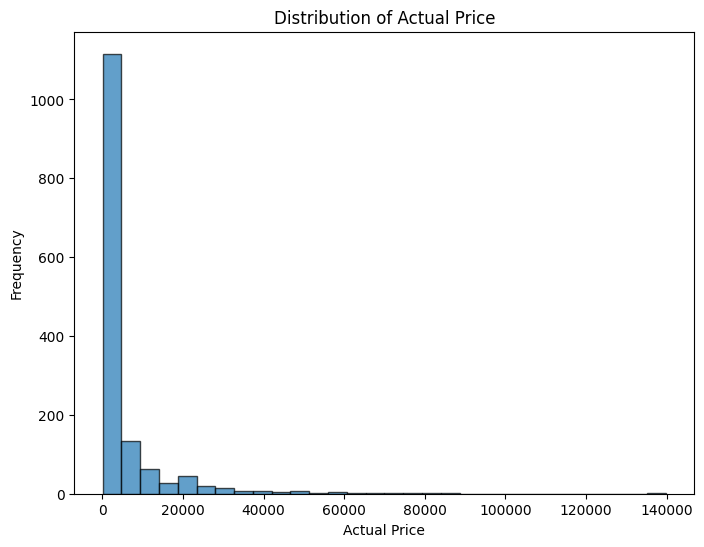

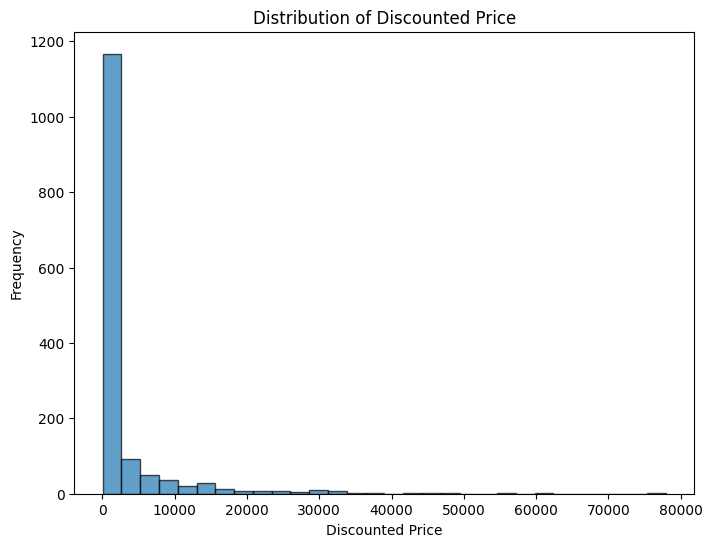

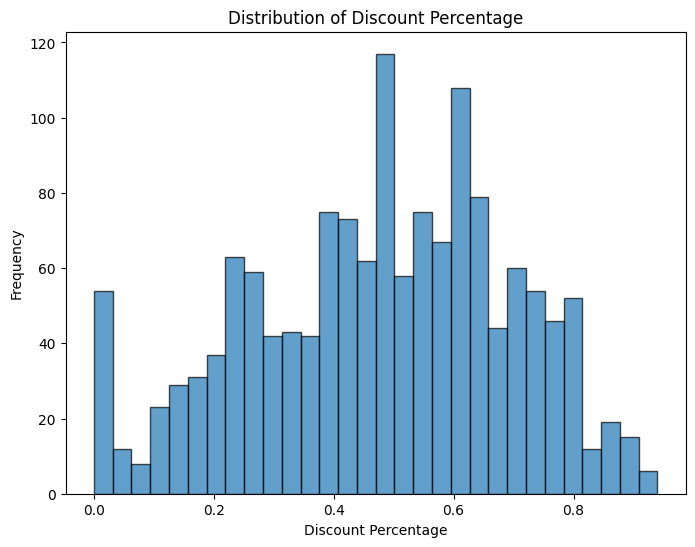

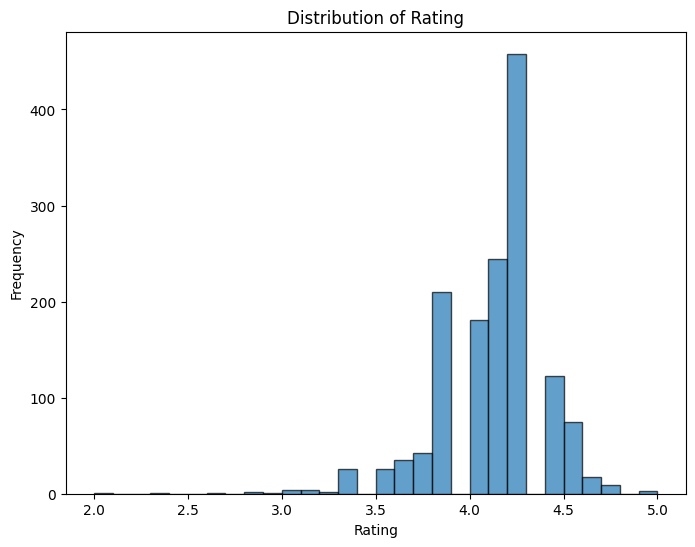

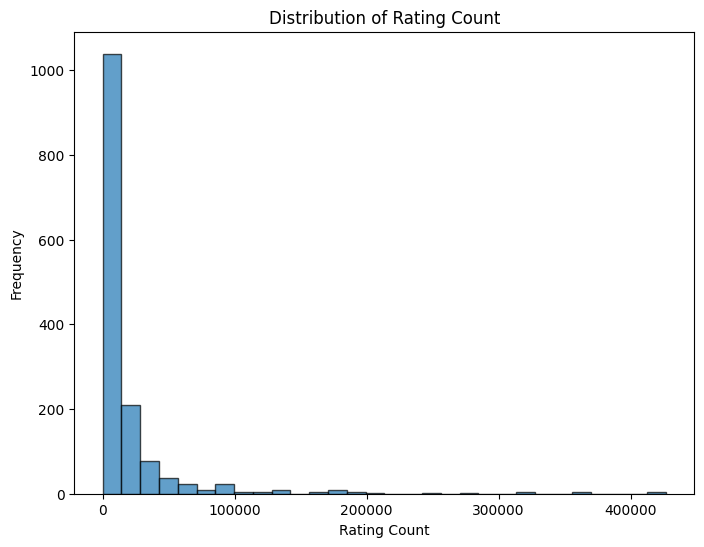

In [392]:
columns_to_plot = ['actual_price', 'discounted_price', 'discount_percentage', 'rating', 'rating_count']

# Loop through each column and plot a histogram
for column in columns_to_plot:
    plt.figure(figsize=(8, 6))  # Set the figure size for each plot
    plt.hist(df[column].dropna(), bins=30, edgecolor='k', alpha=0.7)  # Drop NaN values and plot
    plt.xlabel(column.replace('_', ' ').title())  # Format the column name for the x-axis
    plt.ylabel('Frequency')
    plt.title(f'Distribution of {column.replace("_", " ").title()}')  # Title of the plot
    plt.show()

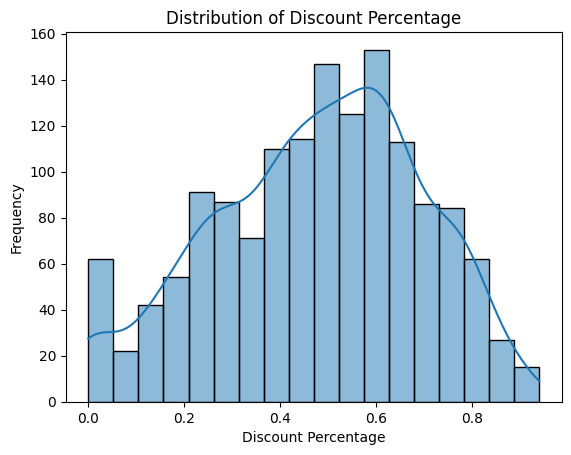

In [393]:
sns.histplot(df['discount_percentage'], kde=True)
plt.title('Distribution of Discount Percentage')
plt.xlabel('Discount Percentage')
plt.ylabel('Frequency')
plt.show()


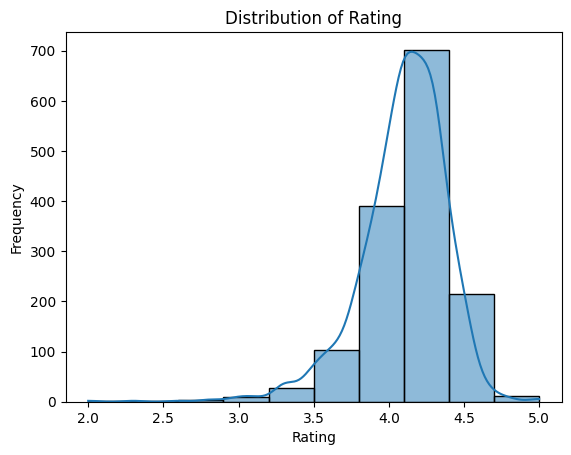

In [394]:
sns.histplot(df['rating'], bins=10, kde=True)
plt.title('Distribution of Rating')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()


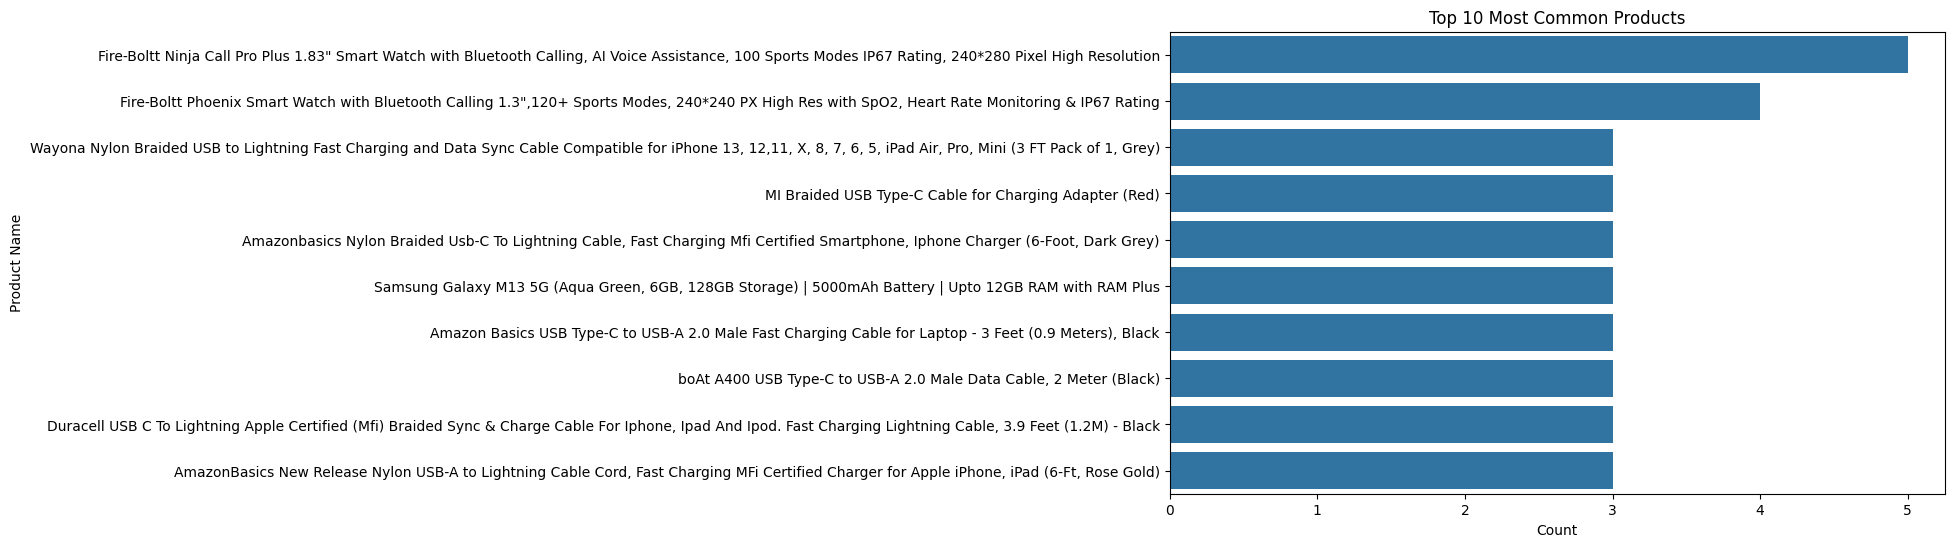

In [395]:
#Top 10 most common products
plt.figure(figsize=(10, 6))
sns.countplot(y=df['product_name'], order=df['product_name'].value_counts().head(10).index)
plt.title('Top 10 Most Common Products')
plt.xlabel('Count')
plt.ylabel('Product Name')
plt.show()


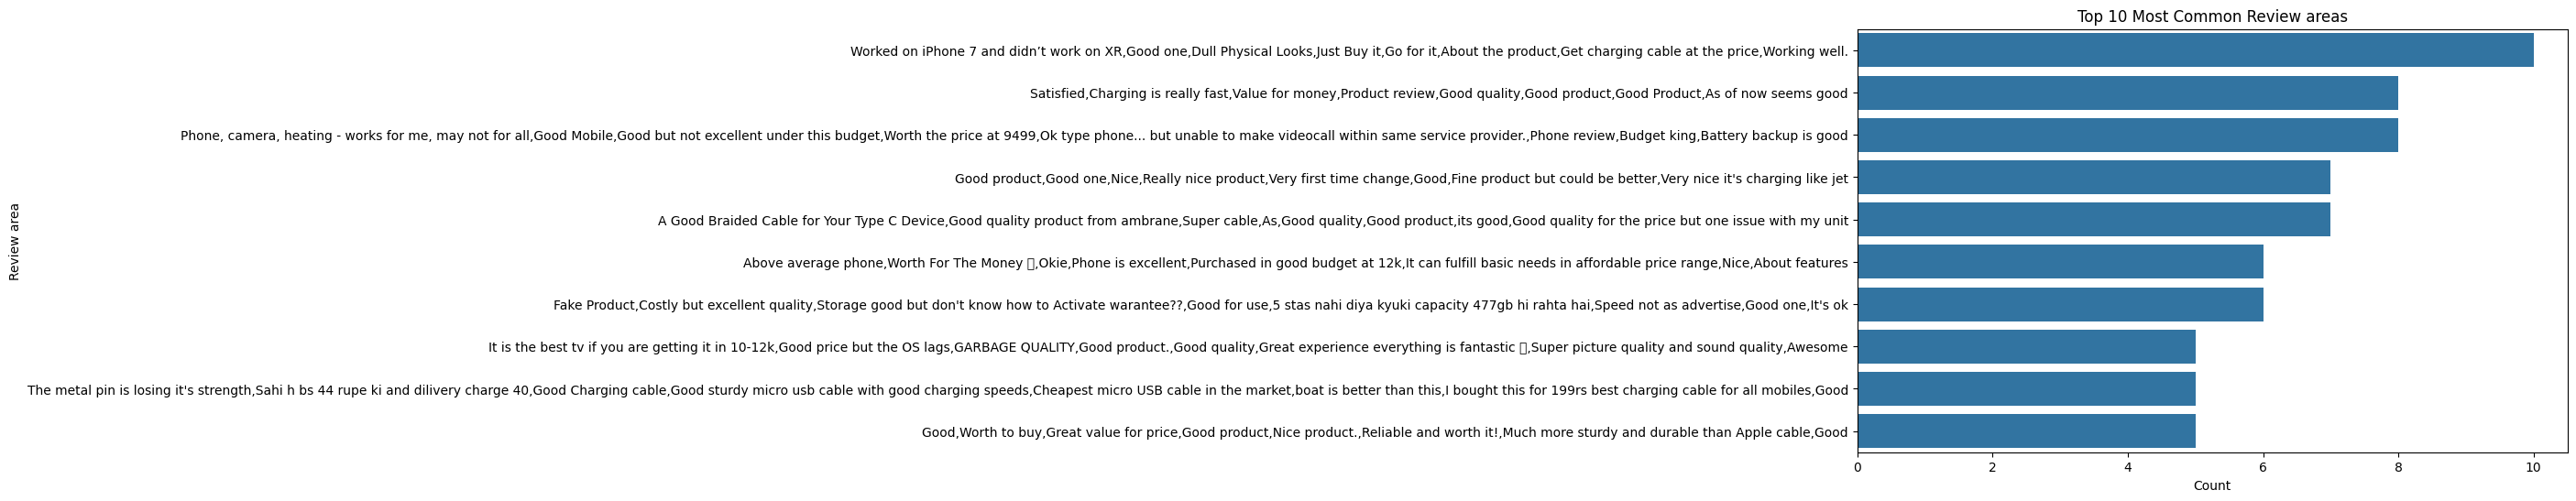

In [396]:
#top 10 areas of reviews
plt.figure(figsize=(10, 6))
sns.countplot(y=df['review_title'], order=df['review_title'].value_counts().head(10).index)
plt.title('Top 10 Most Common Review areas')
plt.xlabel('Count')
plt.ylabel('Review area')
plt.show()


**CONCLUSIONS DRAWN FROM UNIVARIATE ANALYSIS**
1. MOST OF THE PRODUCTS HAVE A LOW PRICE RANGE SO AS TO MIDDLE CLASS USERS WHICH GENERALLY COMPOSE MAJORITY OF THEM
2. THE DISCOUNT PERCENTAGES ARE ALMOST NORMALLY DISTRIBUTED WITH A SLIGHT LEFT SKEWED NATURE WHICH SHOWS THE INTENT OF THE COMPANY TO ATTRACT CUSTOMERS WITH HIGH DISCOUNTS
3. THE RATING COUNT GRAPH IS HIGHLY LEFT SKEWED, CENTRED AROUND 4.3 WHICH IMPLIES THE STRATEGY OF THE COMPANY TO EITHER PROVIDE HIGH RATED PRODUCTS OR TO DISPLAY A HIGHER RATING FOR CUSTOMER ACQUISITION


##**BIVARIATE ANALYSIS**

In [397]:
import pandas as pd

# Get top reviewed products per category
top_reviewed_per_category = (
    df.groupby("category")
    .apply(lambda x: x.nlargest(10, "rating_count"))
    .reset_index(drop=True)
)

# Print only the first 5 rows
print(top_reviewed_per_category.head())


   product_id                                       product_name  \
0  B0912WJ87V  Reffair AX30 [MAX] Portable Air Purifier for C...   
1  B097C564GC  rts [2 Pack] Mini USB C Type C Adapter Plug, T...   
2  B094DQWV9B  Kanget [2 Pack] Type C Female to USB A Male Ch...   
3  B009LJ2BXA  Hp Wired On Ear Headphones With Mic With 3.5 M...   
4  B08SCCG9D4  JBL Commercial CSLM20B Auxiliary Omnidirection...   

                                            category  discounted_price  \
0  Car&Motorbike|CarAccessories|InteriorAccessori...            2339.0   
1  Computers&Accessories|Accessories&Peripherals|...             294.0   
2  Computers&Accessories|Accessories&Peripherals|...             149.0   
3  Computers&Accessories|Accessories&Peripherals|...             649.0   
4  Computers&Accessories|Accessories&Peripherals|...             949.0   

   actual_price  discount_percentage  rating  rating_count  \
0        4000.0                 0.42     3.8        1118.0   
1        4999.0       

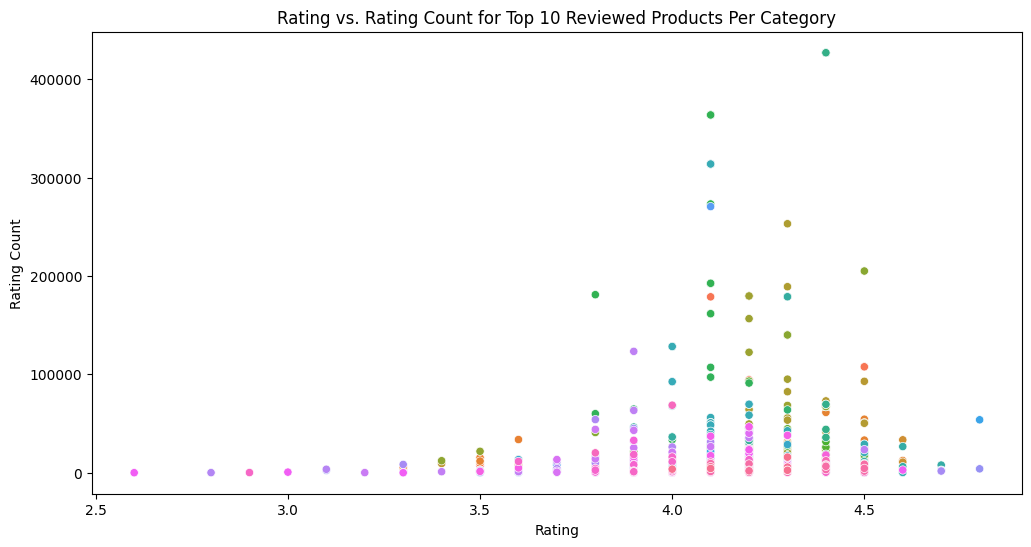

In [398]:
# Scatter plot showing Rating vs. Rating Count for top-reviewed products
plt.figure(figsize=(12, 6))
sns.scatterplot(x='rating', y='rating_count', hue='category', data=top_reviewed_per_category, legend=False)
plt.title("Rating vs. Rating Count for Top 10 Reviewed Products Per Category")
plt.xlabel("Rating")
plt.ylabel("Rating Count")
plt.show()


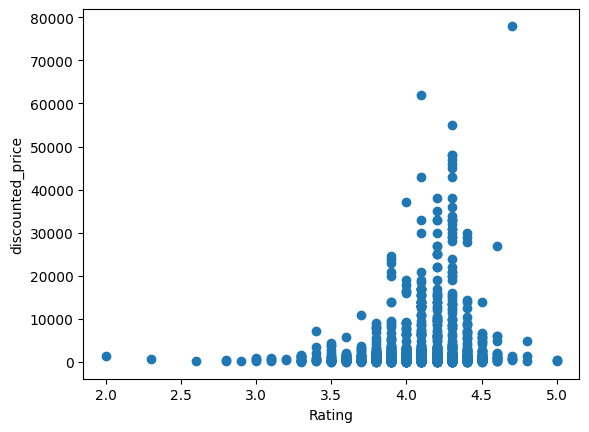

In [399]:
# Plot actual_price vs. rating
plt.scatter(df['rating'], df['discounted_price'])
plt.xlabel('Rating')
plt.ylabel('discounted_price')
plt.show()

In [400]:
# ONE HOT ENCODING OF CATEGORICAL COLUMNS
df = pd.get_dummies(df, columns=['product_id','review_content', 'product_name', 'about_product', 'review_title'], drop_first=True)

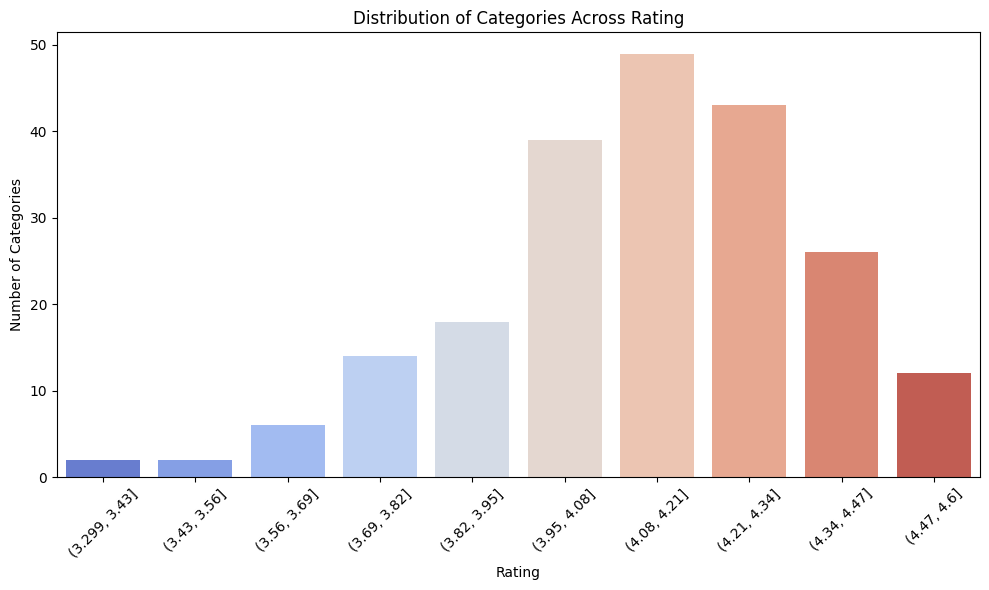

In [401]:

# Check the data type of the "rating" column
if df["rating"].dtype == "object":
    df["rating"] = pd.to_numeric(df["rating"], errors="coerce")  # Handle potential errors

# Calculate the average ratings after ensuring numeric data type
average_ratings = df.groupby("category")["rating"].mean().reset_index()

# Create more bins for the average ratings (let's say 10 bins)
# Using pd.cut() to create bins for the rating
bins = pd.cut(average_ratings['rating'], bins=10)

# Visualize the number of categories in each rating bin
plt.figure(figsize=(10, 6))

# Plot the distribution of categories within each rating bin
sns.countplot(x=bins, data=average_ratings, palette='coolwarm')

# Add labels and title
plt.xlabel('Rating')
plt.ylabel('Number of Categories')
plt.title('Distribution of Categories Across Rating')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Display the plot
plt.tight_layout()
plt.show()


In [402]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['category'] = le.fit_transform(df['category'])

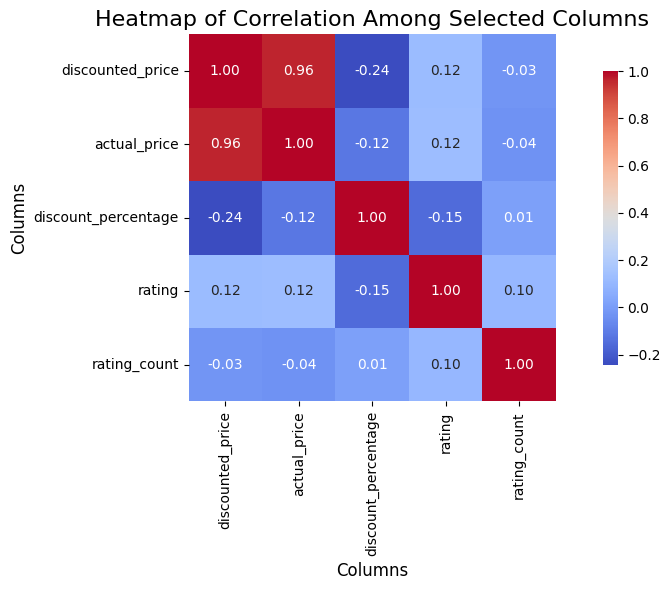

In [403]:
# MAKING CORRELATION MATRIX ND PLOTTING HEATMAP
numeric_cols = ['discounted_price', 'actual_price', 'discount_percentage', 'rating', 'rating_count']

# Calculate the correlation matrix
correlation_matrix = df[numeric_cols].corr()

# Set up the matplotlib figure
plt.figure(figsize=(10, 6))

# Create a heatmap
sns.heatmap(
    correlation_matrix,
    annot=True,               # Display the correlation values on the heatmap
    fmt=".2f",                # Format the annotation to two decimal places
    cmap='coolwarm',          # Choose a color map
    square=True,              # Make squares square-shaped
    cbar_kws={"shrink": .8}  # Adjust color bar size
)

# Add labels and title
plt.title('Heatmap of Correlation Among Selected Columns', fontsize=16)
plt.xlabel('Columns', fontsize=12)
plt.ylabel('Columns', fontsize=12)

# Display the plot
plt.tight_layout()
plt.show()

In [404]:
# Calculate correlation coefficient between product price and sales
correlation_coefficient = np.corrcoef(df['actual_price'], df['rating'])[0, 1]

# Print correlation coefficient
print(correlation_coefficient)

0.1217444960999836


In [405]:
# Mean rating by category
mean_sales_by_category = df.groupby('category')['rating'].mean()
print(mean_sales_by_category)


category
0      3.800000
1      4.150000
2      3.500000
3      3.600000
4      4.050000
         ...   
206    4.250000
207    4.150000
208    4.300000
209    4.133333
210    4.300000
Name: rating, Length: 211, dtype: float64


In [406]:
# T-TEST
import scipy.stats as stats
category_code_1 = 10  # Replace with an actual category code
category_code_2 = 119  # Replace with another actual category code

# Conduct the t-test using the chosen category codes
t_statistic, p_value = stats.ttest_ind(
    df[df['category'] == category_code_1]['rating'].dropna(),
    df[df['category'] == category_code_2]['rating'].dropna()
)

# Print t-statistic and p-value
print("T-statistic:", t_statistic, "P-value:", p_value)

T-statistic: 3.853961248817928 P-value: 0.00014155132139851903


**CONCLUSIONS DRAWN FROM BIVARIATE ANALYSIS**
1. RATING COUNT IS CONCENTRATED MORE ABOUT HIGHER RATING OF AROUNF 4 AND EVEN THE HIGHEST RATING COUNT IS NEAR THIS RATING
2. RATING VS DISCOUNTED PRICE FOLLOWS A LEFT SKEWED NORMAL DISTRIBUTION WITH PEAK AROUND 4.2 RATING
3. EVEN THE RATING VS CATEGORY IS A LEFT SKEWED NORMAL DISTRIBUTION AND 4-4.2 RATED ARE MAXIMUM CATEGORIES OF PRODUCTS
4. ALL THIS TELLS US HOW FOCUSSED THE COMPANY IS ON HIGH RATED PRODUCTS
5. CORRELATION COEFFICIENT

   Correlation Coefficient: 0.1217

   Conclusion: This is a weak positive correlation. It suggests that there is a slight tendency for products with higher actual prices to receive better ratings, but the relationship is not strong.
6. MEAN RATING BY CATEGORY:
Categories range from 0 to 210, with each category showing a different mean rating.

   Conclusion: Different categories show variation in average ratings, indicating that some product categories are rated more favorably than others.
7. T-TEST BETWEEN TWO CATEGORIES:

   T-statistic: 3.85

   P-value: 0.00014

   Conclusion: The small p-value indicates that there is a statistically significant difference in the mean ratings between category 10 and category 119. Therefore, we can reject the null hypothesis that these two categories have the same average rating.
8. KEY OBSERVATIONS FROM THE HEATMAP:-

    a. Discounted Price & Actual Price:
    High positive correlation (0.96): This suggests that as the actual price increases, the discounted price also increases. This is expected since discounted prices are generally proportional to the actual price.

    b. Discount Percentage & Discounted Price:
    Moderate negative correlation (-0.24): As the discounted price increases, the discount percentage tends to decrease. This might indicate that higher-
   priced products are given lower discounts in percentage terms, though the absolute value might still be substantial.

    c. Discount Percentage & Actual Price:
    Weak negative correlation (-0.12): This suggests that as the actual price increases, the discount percentage slightly decreases. Similar reasoning applies as with the discounted price.

    d. Rating & Discount Percentage:
    Weak negative correlation (-0.15): Higher discount percentages are associated with slightly lower ratings. This could suggest that products with higher discounts might not always have the best ratings.

    e. Rating & Discounted/Actual Price:
    Weak positive correlation (0.12): Both the discounted price and actual price have a small positive relationship with ratings. This might suggest that higher-priced products tend to have slightly higher ratings, although the relationship is weak.

    f. Rating Count & Other Variables:
    Minimal correlations (close to 0): There's little to no correlation between rating count and variables like discounted price, actual price, discount percentage, or even rating. This might suggest that the number of reviews doesn't strongly depend on price or ratings in this dataset.

